## MIDS - Spotify Base Data Review

In [1]:
## to mount GoogleDrive
from google.colab import drive
import os 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/to_mount')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# base modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.metrics

# non-base no import
from pathlib import Path
from bs4 import BeautifulSoup
#from lyricsgenius import Genius
import requests
import seaborn as sns
import json
import xgboost as xgb
import re

In [3]:
#!pip install spotipy
#!pip install pymusixmatch

In [4]:
# import packages
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [5]:
nltk.download(["names","stopwords","state_union","twitter_samples","movie_reviews", "averaged_perceptron_tagger","vader_lexicon","punkt"])

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
#Spotify creds
cid = Path('_keys/cid.txt').read_text()
secret = Path('_keys/secret.txt').read_text()

#Genius creds
# genius_cid = Path('_keys/genius_cid.txt').read_text()
# genius_secret = Path('_keys/genius_secret.txt').read_text()

#Musixmatch creds
musix_cid = Path('_keys/musix_id.txt').read_text()

In [7]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# genius = Genius(genius_cid)

In [8]:
data = pd.read_csv('_data/charts.csv')

In [9]:
data.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [10]:
print(data['chart'].value_counts())
print(data['region'].value_counts())

## suggest narrowing scope to just viral50 in US

top200     20321904
viral50     5851610
Name: chart, dtype: int64
Argentina        455308
United States    455057
Austria          454593
Brazil           454439
Australia        453103
                  ...  
Ukraine          127544
Russia           126837
Luxembourg        98053
Andorra           79592
South Korea       76276
Name: region, Length: 70, dtype: int64


In [47]:
use_songs = data.loc[(data.chart == 'viral50') & 
                     (data.region == 'United States')]

In [12]:
print("number of unique songs: ", len(use_songs.url.unique()))
print("number of unique artists: ", len(use_songs.artist.unique()))

number of unique songs:  7974
number of unique artists:  4380


In [48]:
unique_url = use_songs['url'].unique()

In [ ]:
## get spotify data popularity
def popularity(df):
    empty = []
    use_keys = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo']
    for i in df:
      #print(i)
      series_track = pd.Series(sp.track(i))

      series_analysis_base = pd.Series(sp.audio_features(i)[0])
      series_analysis = pd.Series({k: v for k, v in series_analysis_base.items() if k in use_keys})

      series_track_full = pd.concat([series_track, series_analysis])
      empty.append(series_track_full)

    df2 = pd.DataFrame(empty)
    return df2

spotify_pull = popularity(unique_url)

In [61]:
spotify_pull.head()

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,...,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AM, AO, AR, AT, AU, AZ, BB, BD, B...",1,199741,True,{'isrc': 'TCADD1721892'},{'spotify': 'https://open.spotify.com/track/2A...,https://api.spotify.com/v1/tracks/2AEzMPR01sg1...,2AEzMPR01sg1wsXurYrgDx,...,0.810,0.342,1.0,-8.801,0.0892,0.7020,0.027400,0.1100,0.0881,77.515
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,234285,False,{'isrc': 'USAT21702382'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/57p8CBvPOxrv...,57p8CBvPOxrvyCbn6ttl5r,...,0.653,0.910,10.0,-3.360,0.0566,0.0079,0.000000,0.3180,0.0921,126.047
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,261614,True,{'isrc': 'QZ8TY1700008'},{'spotify': 'https://open.spotify.com/track/0R...,https://api.spotify.com/v1/tracks/0RYXEibxMami...,0RYXEibxMami3QuT8kn4Iz,...,0.922,0.583,5.0,-4.982,0.0753,0.0098,0.000000,0.0962,0.4940,136.043
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,162585,False,{'isrc': 'GBAHS1700564'},{'spotify': 'https://open.spotify.com/track/5o...,https://api.spotify.com/v1/tracks/5o4yGlG0PfeV...,5o4yGlG0PfeVUa6ClIyOxq,...,0.867,0.545,2.0,-5.192,0.0625,0.0646,0.000289,0.0505,0.5250,139.943
4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AG, AL, AM, AO, AR, AT, AU, AZ, BA, BB, B...",1,190427,True,{'isrc': 'GBHMU1700037'},{'spotify': 'https://open.spotify.com/track/7F...,https://api.spotify.com/v1/tracks/7F9vK8hNFMml...,7F9vK8hNFMml4GtHsaXui6,...,0.683,0.530,5.0,-4.918,0.1420,0.2070,0.000000,0.3940,0.6450,75.016


In [30]:
spotify_pull.to_csv('viral50_use.csv')

In [31]:
spotify_pull = pd.read_csv('viral50_use.csv')

In [32]:
# parse url from JSON response
def parse_url(df):
  empty = []
  for i in df['external_urls']:
    line_artists = []
    try:
      artist_lists = json.loads(i.replace("\'", "\""))
    except:
      artists_lists = []
    line_artists.append(artist_lists['spotify'])
    empty.append(line_artists)
  return empty


spotify_pull['full_url'] = parse_url(spotify_pull)
spotify_pull['url'] = spotify_pull.apply(lambda row: row.full_url[0], axis=1)

In [33]:
spotify_pull.head()

,Unnamed: 0,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,...,codestring,code_version,echoprintstring,echoprint_version,synchstring,synch_version,rhythmstring,rhythm_version,full_url,url
0,0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,218319,False,{'isrc': 'GBBPW1700118'},{'spotify': 'https://open.spotify.com/track/6X...,https://api.spotify.com/v1/tracks/6XgtAeRYmbr4...,...,eJxNmomR7TYMBFNRCLyP_BNz9_Btfduu8pJPEkkcgwHAu-...,3.15,eJzlnQuSBDeOZK8U_JPH4ff-R9jnyB6lWqtg7WytrMdsZT...,4.12,eJyNWIdxJDkMTGVCIEGff2LXBpzV6u6rviStxpAwjYbhRp...,1.0,eJxdnFuW5LiuQ6eSQ9D7Mf-JXQEbjupzP3JVdmTYligSBE...,1.0,[https://open.spotify.com/track/6XgtAeRYmbr4Of...,https://open.spotify.com/track/6XgtAeRYmbr4OfE...
1,1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AM', 'AO', 'AR', 'AT', 'AU...",1,199741,True,{'isrc': 'TCADD1721892'},{'spotify': 'https://open.spotify.com/track/2A...,https://api.spotify.com/v1/tracks/2AEzMPR01sg1...,...,eJxdmlmi5CgMBK_iI7Av97_YRAj8yj0_3Q9sg9CSSolaae...,3.15,eJztnQnS3DaSha9E7MBxsN7_CPNllkdUK8Ss1pRk2R5Hd7...,4.12,eJxdlomVIzkMQ1NRCCVSZ_6JLT6onunZZ79yWaJ4ASQV8c...,1.0,eJx1WwmSYzsKvIqPoAVt97_YkItk1_RMxP_RVfZbJARJkl...,1.0,[https://open.spotify.com/track/2AEzMPR01sg1ws...,https://open.spotify.com/track/2AEzMPR01sg1wsX...
2,2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,234285,False,{'isrc': 'USAT21702382'},{'spotify': 'https://open.spotify.com/track/57...,https://api.spotify.com/v1/tracks/57p8CBvPOxrv...,...,eJxdmwuW7CgORLeSSwDMd_8bm3sDv8rsOT3TXcY2FkIKhS...,3.15,eJzlnQm65LiRpK9E7MBxsN7_CPObh5RRlV8TbzQpzdbdkk...,4.12,eJxtWgmW5DoIu0qOEIO33P9iP0gCp3r-m57uSuIFswhByu...,1.0,eJy1XFmW5DYOvEoegfty_4sNYiGlrK4e-2PmPbedzpQoLk...,1.0,[https://open.spotify.com/track/57p8CBvPOxrvyC...,https://open.spotify.com/track/57p8CBvPOxrvyCb...
3,3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,261614,True,{'isrc': 'QZ8TY1700008'},{'spotify': 'https://open.spotify.com/track/0R...,https://api.spotify.com/v1/tracks/0RYXEibxMami...,...,eJxdnAmS7agORLdylwBi3v_GOk8Ku_z6d8SPB9cDCA2plF...,3.15,eJztnQuW5LiRbLdEAsRvOfjufwnvmkerWJVHRKgmKqXWzJ...,4.12,eJyFWAm25aYO3ApLQCAG739jUVVJvv7pn-T0bT-MGYSGUo...,1.0,eJx9XAly5DgO_Eo9gffx_48N8wClst0TsbNtlyUKBHEkEl...,1.0,[https://open.spotify.com/track/0RYXEibxMami3Q...,https://open.spotify.com/track/0RYXEibxMami3Qu...
4,4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT...",1,162585,False,{'isrc': 'GBAHS1700564'},{'spotify': 'https://open.spotify.com/track/5o...,https://api.spotify.com/v1/tracks/5o4yGlG0PfeV...,...,eJxVmgeWJLuRBK-SR4AW97_YmjlqPnvJx2EDlQII4eHhyD...,3.15,eJztnQuWJDeObLfk_JPL4Xf_S5hrCHWFukbBHJ2cnNZ552...,4.12,eJxtWgm2JCEIu4pHKHGt-19sJAlq9Z8387trcUGEELDNnv...,1.0,eJxtWgly5DgM-4qfoJvS_z82BEDK7tRU7WySbh8SDxAEVW...,1.0,[https://open.spotify.com/track/5o4yGlG0PfeVUa...,https://open.spotify.com/track/5o4yGlG0PfeVUa6...


In [34]:
max_position = use_songs.groupby('url').agg({'rank': 'min'})
max_position.reset_index()

spotify_pull_join = pd.merge(spotify_pull.reset_index(),
                            max_position.reset_index(),
                            how='left', 
                            on='url')

Plot distribution of popularity score.

[Text(0.5, 1.0, 'Total Popularity Distribution')]

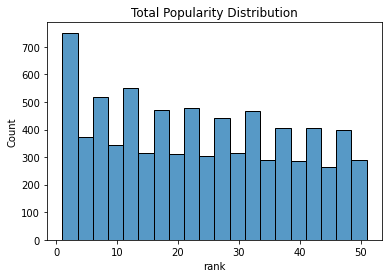

In [ ]:
sns.histplot(data = spotify_pull_join
            ,x = 'rank'
            ).set(title='Total Popularity Distribution')

In [35]:
# parse artist names from JSON response
def parse_artist(df):
  empty = []
  for i in df['artists']:
    line_artists = []
    try:
      artist_lists = json.loads(i.replace("\'", "\""))
    except:
      #print(i)
      artists_lists = []
    for j in artist_lists:
      line_artists.append(j['name'])
    empty.append(line_artists)
  return empty


spotify_pull_join['artist_names'] = parse_artist(spotify_pull_join)
spotify_pull_join['first_artist'] = spotify_pull_join.apply(lambda row: row.artist_names[0], axis=1)

In [36]:
out = pd.DataFrame(spotify_pull_join.first_artist.value_counts())
out.head(10)

,first_artist
Drake,63
Logic,34
Prince,32
DMX,29
Ed Sheeran,28
Juice WRLD,26
Post Malone,25
Billie Eilish,25
Chris Stapleton,23
Mac Miller,23


[Text(0.5, 1.0, 'Arist Song Count')]

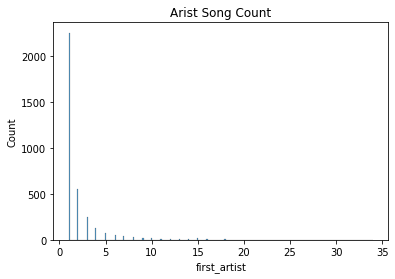

In [ ]:
sns.histplot(data = out.loc[out['first_artist'] < 40]
            ,x = 'first_artist'
            ).set(title='Arist Song Count')

In [37]:
use_cols = ['href', 'rank', 'name', 'first_artist', 'tempo', 'loudness', '']
electro_short_join = spotify_pull_join[use_cols]

In [38]:
electro_short_join.head()

,href,rank,name,first_artist
0,https://api.spotify.com/v1/tracks/6XgtAeRYmbr4...,32,LMK,Kelela
1,https://api.spotify.com/v1/tracks/2AEzMPR01sg1...,1,Turn Up On the Weekend,Branchez
2,https://api.spotify.com/v1/tracks/57p8CBvPOxrv...,2,Would You Ever,Skrillex
3,https://api.spotify.com/v1/tracks/0RYXEibxMami...,3,Marmalade (feat. Lil Yachty),Macklemore
4,https://api.spotify.com/v1/tracks/5o4yGlG0PfeV...,4,Boys,Charli XCX


In [44]:
list(spotify_pull_join.columns)

['index',
 'Unnamed: 0',
 'album',
 'artists',
 'available_markets',
 'disc_number',
 'duration_ms',
 'explicit',
 'external_ids',
 'external_urls',
 'href',
 'id',
 'is_local',
 'name',
 'popularity',
 'preview_url',
 'track_number',
 'type',
 'uri',
 'num_samples',
 'duration',
 'sample_md5',
 'offset_seconds',
 'window_seconds',
 'analysis_sample_rate',
 'analysis_channels',
 'end_of_fade_in',
 'start_of_fade_out',
 'loudness',
 'tempo',
 'tempo_confidence',
 'time_signature',
 'time_signature_confidence',
 'key',
 'key_confidence',
 'mode',
 'mode_confidence',
 'codestring',
 'code_version',
 'echoprintstring',
 'echoprint_version',
 'synchstring',
 'synch_version',
 'rhythmstring',
 'rhythm_version',
 'full_url',
 'url',
 'rank',
 'artist_names',
 'first_artist']

In [39]:
## Create dictionary to track model results
#results = {}
#
#def add_results(y_pred, model_name):
#    ## Add results of test data to tracker, with user input to ensure data is overwritten on purpose
#    if model_name in results.keys():
#        userIn = input("Model already in dictionary. Add? ").lower()
#        if userIn == 'yes':
#            results[model_name] = round(sklearn.metrics.roc_auc_score(y_test, y_pred), 4)
#        else:
#            pass
#    else:
#        results[model_name] = round(sklearn.metrics.roc_auc_score(y_test, y_pred), 4)
#    print(results)


## Create dictionary to track model results
results = {}

def add_results(y_pred, model_name):
    ## Add results of test data to tracker, with user input to ensure data is overwritten on purpose
    if model_name in results.keys():
        userIn = input("Model already in dictionary. Add? ").lower()
        if userIn == 'yes':
            results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
        else:
            pass
    else:
        results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
    print(results)

## pull from MusixMatch

In [ ]:
musixmatch = Musixmatch(musix_cid)

def parse_lyrics(df):
  empty = []
  for row, artist in df.first_artist.iteritems():
    song_title = df['name'].loc[row]
    lyrics_return = ''
    #print(song_title)
    #print(artist)
    try:
      track_return = musixmatch.matcher_track_get(song_title, artist)
      if track_return['message']['body']['track']['has_lyrics'] == 1:
        lyrics_return = musixmatch.track_lyrics_get(track_return['message']['body']['track']['track_id'])['message']['body']['lyrics']['lyrics_body']
    except:
      lyrics_return = ''
    empty.append(lyrics_return)
  return empty

full_lyrics = parse_lyrics(electro_short_join)

In [ ]:
electro_short_join['lyrics'] = full_lyrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
## clean lyrics
electro_short_join['lyrics_clean'] = electro_short_join['lyrics'].str.replace('******* This Lyrics is NOT for Commercial use *******\n(1409622602394)', '',regex=False).str.replace('\n', ' ', regex=False)
electro_short_join['char_len'] = electro_short_join['lyrics_clean'].str.len()

In [ ]:
electro_short_join.to_csv('rank_viral_w_lyrics.csv')

In [ ]:
electro_short_join = pd.read_csv('rank_viral_w_lyrics.csv')

In [ ]:
# prep sentiment analysis
sia = SentimentIntensityAnalyzer()

In [ ]:
def get_sentiment(df):
  empty = []

  for lyrics in df.lyrics_clean:

    if pd.isna(lyrics):
      lyrics = ''

    #print(lyrics)
    output = sia.polarity_scores(lyrics)
    empty.append(output)
    
  return empty

sentiment_scores = pd.DataFrame(get_sentiment(electro_short_join))
final_sentiment = pd.concat([electro_short_join.reset_index(), sentiment_scores.reset_index()], axis=1)

In [ ]:
## bring in GloVe
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_filename = 'glove.twitter.27B.100d.txt'

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec('glove.twitter.27B.100d.txt', word2vec_output_file)

# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
v = model.get_vector('king')
D = v.shape[0]

X = np.zeros((len(final_sentiment.lyrics_clean), D))
n = 0
emptycount = 0

for sentence in final_sentiment.lyrics_clean:
  
  if pd.isna(sentence):
    sentence = ''
  
  tokens = sentence.split()
  vecs = []
  m = 0
  
  for word in tokens:
    word = word.lower()
    try:
      # throws KeyError if word not found
      vec = model.get_vector(word)
      vecs = np.append(vecs, vec)
      m += 1
    except KeyError:
      pass
    
  if len(vecs) > 0:
    vecs = np.array(vecs)
    X[n] = vecs.mean(axis=0)
  else:
    emptycount += 1  
  n += 1

print(emptycount)
print(n)

1063
7974


In [ ]:
GloVe_cols = ['GloVe' + str(x) for x in range(D)]

df_GloVe = pd.DataFrame(X)
df_GloVe.columns = GloVe_cols

final_sentiment2 = pd.concat([final_sentiment.reset_index(), df_GloVe.reset_index()], axis=1)
final_sentiment2['target'] = np.where(final_sentiment2['rank'] <= 10, 1, 0)

In [ ]:
use_cols = ['neg', 'neu', 'pos', 'compound', 'target']
use_cols = use_cols + GloVe_cols

In [ ]:
electro_agg_metrics = final_sentiment2[use_cols]

In [ ]:
agg_cols = {'neg':'mean','neu':'mean','pos':'mean','compound':'mean',
            'GloVe0': 'mean','GloVe1': 'mean','GloVe2': 'mean','GloVe3': 'mean','GloVe4': 'mean',
            'GloVe5': 'mean','GloVe6': 'mean','GloVe7': 'mean','GloVe8': 'mean','GloVe9': 'mean',
            'GloVe10': 'mean','GloVe11': 'mean','GloVe12': 'mean','GloVe13': 'mean','GloVe14': 'mean',
            'GloVe15': 'mean','GloVe16': 'mean','GloVe17': 'mean','GloVe18': 'mean','GloVe19': 'mean',
            'GloVe20': 'mean','GloVe21': 'mean','GloVe22': 'mean','GloVe23': 'mean','GloVe24': 'mean',
            'GloVe25': 'mean','GloVe26': 'mean','GloVe27': 'mean','GloVe28': 'mean','GloVe29': 'mean',
            'GloVe30': 'mean','GloVe31': 'mean','GloVe32': 'mean','GloVe33': 'mean','GloVe34': 'mean',
            'GloVe35': 'mean','GloVe36': 'mean','GloVe37': 'mean','GloVe38': 'mean','GloVe39': 'mean',
            'GloVe40': 'mean','GloVe41': 'mean','GloVe42': 'mean','GloVe43': 'mean','GloVe44': 'mean',
            'GloVe45': 'mean','GloVe46': 'mean','GloVe47': 'mean','GloVe48': 'mean','GloVe49': 'mean',
            'GloVe50': 'mean','GloVe51': 'mean','GloVe52': 'mean','GloVe53': 'mean','GloVe54': 'mean',
            'GloVe55': 'mean','GloVe56': 'mean','GloVe57': 'mean','GloVe58': 'mean','GloVe59': 'mean',
            'GloVe60': 'mean','GloVe61': 'mean','GloVe62': 'mean','GloVe63': 'mean','GloVe64': 'mean',
            'GloVe65': 'mean','GloVe66': 'mean','GloVe67': 'mean','GloVe68': 'mean','GloVe69': 'mean',
            'GloVe70': 'mean','GloVe71': 'mean','GloVe72': 'mean','GloVe73': 'mean','GloVe74': 'mean',
            'GloVe75': 'mean','GloVe76': 'mean','GloVe77': 'mean','GloVe78': 'mean','GloVe79': 'mean',
            'GloVe80': 'mean','GloVe81': 'mean','GloVe82': 'mean','GloVe83': 'mean','GloVe84': 'mean',
            'GloVe85': 'mean','GloVe86': 'mean','GloVe87': 'mean','GloVe88': 'mean','GloVe89': 'mean',
            'GloVe90': 'mean','GloVe91': 'mean','GloVe92': 'mean','GloVe93': 'mean','GloVe94': 'mean',
            'GloVe95': 'mean','GloVe96': 'mean','GloVe97': 'mean','GloVe98': 'mean','GloVe99': 'mean',
            'target': 'sum'}

electro_agg_metrics = final_sentiment2.groupby('first_artist').agg(agg_cols)


In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(electro_agg_metrics.drop('target', axis = 1), 
                                                                            electro_agg_metrics.target,
                                                    random_state = 1111,
                                                    test_size = 0.3)

In [ ]:
XGB_MVP = xgb.XGBRegressor(objective='reg:squarederror',
                                seed=100).fit(X_train, y_train)
add_results(XGB_MVP.predict(X_test), "XGB_Base_lyrics")

{'XGB_Base_lyrics': 1.0}


In [ ]:
## Run GridSearchCV on max_depth, min_child_weight, n_estimators, and subsample

param_test = {
 'max_depth':range(2,5,1),
 'min_child_weight':range(3,10,2),
 'subsample':[i/100.0 for i in range(70,90,5)],
 'n_estimator':range(150,300,50)
}

gsearch1 = sklearn.model_selection.GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eta=0.05,
                                                                           seed=100),param_grid=param_test, 
                                                                           cv=4)
gsearch1.fit(X_train, y_train)
gsearch1.best_estimator_

XGBRegressor(eta=0.05, max_depth=4, min_child_weight=3, n_estimator=150,
             objective='reg:squarederror', seed=100, subsample=0.85)

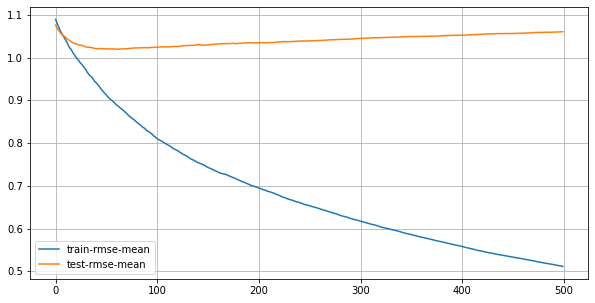

In [ ]:
## Select final number of estimators
params = {'eta':0.05, 'seed':100, 
         'max_depth':4, 'min_child_weight':3, 'subsample':0.85, 'objective':'reg:squarederror'}

## Run CV to determine the number of round
CVRun = xgb.cv(
            params=params,
            dtrain=xgb.DMatrix(X_train, label=y_train),
            num_boost_round=500,
            nfold=4,
            metrics='rmse',
            seed=100)

CVRun.drop(['train-rmse-std', 'test-rmse-std'], axis=1, inplace=True)
CVRun.plot(figsize = (10,5), grid = True)

In [ ]:
## Selected 300 as the number of rounds to avoid over fitting

XGB_hyperparam = xgb.train(params, xgb.DMatrix(X_train, label=y_train), 120)
add_results(XGB_hyperparam.predict(xgb.DMatrix(X_test)), "XGB_Hyperparam_lyrics")

Model already in dictionary. Add? Yes
{'XGB_Base_lyrics': 1.0, 'XGB_Hyperparam_lyrics': 0.99498743710662}


In [ ]:
### add in artist meta data
artist_meta = pd.read_csv('viral50_dataset_artist_metadata.csv')

select_artist = ['first_artist', 'artist_popularity', 'genres', 'followers', 'avg_related_artist_pop']
#artist_meta.head()

In [ ]:
sentiment_meta = pd.merge(final_sentiment2, artist_meta[select_artist].drop_duplicates(subset='first_artist'), 
                          how = 'left', on = 'first_artist')

In [ ]:
electro_agg_metrics = sentiment_meta[use_cols + ['avg_related_artist_pop', 'artist_popularity', 'followers']]

## clean up col types
sentiment_meta['avg_related_artist_pop'] = pd.to_numeric(sentiment_meta['avg_related_artist_pop'], errors='coerce')
sentiment_meta['artist_popularity'] = pd.to_numeric(sentiment_meta['artist_popularity'], errors='coerce')
sentiment_meta['followers'] = pd.to_numeric(sentiment_meta['followers'], errors='coerce')

In [ ]:
agg_cols = {'neg':'mean','neu':'mean','pos':'mean','compound':'mean',
            'GloVe0': 'mean','GloVe1': 'mean','GloVe2': 'mean','GloVe3': 'mean','GloVe4': 'mean',
            'GloVe5': 'mean','GloVe6': 'mean','GloVe7': 'mean','GloVe8': 'mean','GloVe9': 'mean',
            'GloVe10': 'mean','GloVe11': 'mean','GloVe12': 'mean','GloVe13': 'mean','GloVe14': 'mean',
            'GloVe15': 'mean','GloVe16': 'mean','GloVe17': 'mean','GloVe18': 'mean','GloVe19': 'mean',
            'GloVe20': 'mean','GloVe21': 'mean','GloVe22': 'mean','GloVe23': 'mean','GloVe24': 'mean',
            'GloVe25': 'mean','GloVe26': 'mean','GloVe27': 'mean','GloVe28': 'mean','GloVe29': 'mean',
            'GloVe30': 'mean','GloVe31': 'mean','GloVe32': 'mean','GloVe33': 'mean','GloVe34': 'mean',
            'GloVe35': 'mean','GloVe36': 'mean','GloVe37': 'mean','GloVe38': 'mean','GloVe39': 'mean',
            'GloVe40': 'mean','GloVe41': 'mean','GloVe42': 'mean','GloVe43': 'mean','GloVe44': 'mean',
            'GloVe45': 'mean','GloVe46': 'mean','GloVe47': 'mean','GloVe48': 'mean','GloVe49': 'mean',
            'GloVe50': 'mean','GloVe51': 'mean','GloVe52': 'mean','GloVe53': 'mean','GloVe54': 'mean',
            'GloVe55': 'mean','GloVe56': 'mean','GloVe57': 'mean','GloVe58': 'mean','GloVe59': 'mean',
            'GloVe60': 'mean','GloVe61': 'mean','GloVe62': 'mean','GloVe63': 'mean','GloVe64': 'mean',
            'GloVe65': 'mean','GloVe66': 'mean','GloVe67': 'mean','GloVe68': 'mean','GloVe69': 'mean',
            'GloVe70': 'mean','GloVe71': 'mean','GloVe72': 'mean','GloVe73': 'mean','GloVe74': 'mean',
            'GloVe75': 'mean','GloVe76': 'mean','GloVe77': 'mean','GloVe78': 'mean','GloVe79': 'mean',
            'GloVe80': 'mean','GloVe81': 'mean','GloVe82': 'mean','GloVe83': 'mean','GloVe84': 'mean',
            'GloVe85': 'mean','GloVe86': 'mean','GloVe87': 'mean','GloVe88': 'mean','GloVe89': 'mean',
            'GloVe90': 'mean','GloVe91': 'mean','GloVe92': 'mean','GloVe93': 'mean','GloVe94': 'mean',
            'GloVe95': 'mean','GloVe96': 'mean','GloVe97': 'mean','GloVe98': 'mean','GloVe99': 'mean',
            'followers': 'mean','artist_popularity': 'mean', 'avg_related_artist_pop': 'mean',
            'target': 'sum'}

electro_agg_metrics = sentiment_meta.groupby('first_artist').agg(agg_cols)


In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(electro_agg_metrics.drop('target', axis = 1), 
                                                                            electro_agg_metrics.target,
                                                    random_state = 1111,
                                                    test_size = 0.3)

In [ ]:
XGB_MVP = xgb.XGBRegressor(objective='reg:squarederror',
                                seed=100).fit(X_train, y_train)
add_results(XGB_MVP.predict(X_test), "XGB_Base_lyrics_meta")

{'XGB_Base_lyrics_meta': 0.8888194417315589}


In [ ]:
## Run GridSearchCV on max_depth, min_child_weight, n_estimators, and subsample

param_test = {
 'max_depth':range(2,5,1),
 'min_child_weight':range(3,10,2),
 'subsample':[i/100.0 for i in range(70,90,5)],
 'n_estimator':range(150,300,50)
}

gsearch1 = sklearn.model_selection.GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eta=0.05,
                                                                           seed=100),param_grid=param_test, 
                                                                           cv=4)
gsearch1.fit(X_train, y_train)
gsearch1.best_estimator_

XGBRegressor(eta=0.05, min_child_weight=3, n_estimator=150,
             objective='reg:squarederror', seed=100, subsample=0.85)

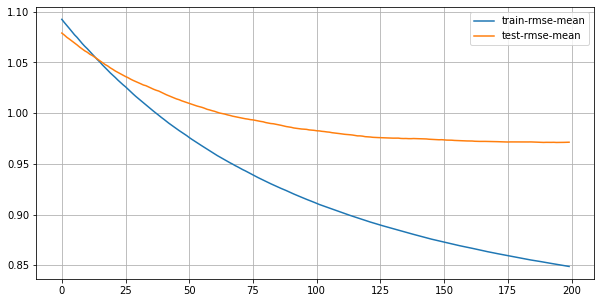

In [ ]:
## Select final number of estimators
params = {'eta':0.01, 'seed':100, 
         'max_depth':3, 'min_child_weight':3, 'subsample':0.85, 'objective':'reg:squarederror'}

## Run CV to determine the number of round
CVRun = xgb.cv(
            params=params,
            dtrain=xgb.DMatrix(X_train, label=y_train),
            num_boost_round=200,
            nfold=4,
            metrics='rmse',
            seed=100)

CVRun.drop(['train-rmse-std', 'test-rmse-std'], axis=1, inplace=True)
CVRun.plot(figsize = (10,5), grid = True)

In [ ]:
## Selected 300 as the number of rounds to avoid over fitting

XGB_hyperparam = xgb.train(params, xgb.DMatrix(X_train, label=y_train), 130)
add_results(XGB_hyperparam.predict(xgb.DMatrix(X_test)), "XGB_Hyperparam_lyrics_meta")

Model already in dictionary. Add? Yes
{'XGB_Base_lyrics_meta': 0.8888194417315589, 'XGB_Hyperparam_lyrics_meta': 0.9219544457292888}


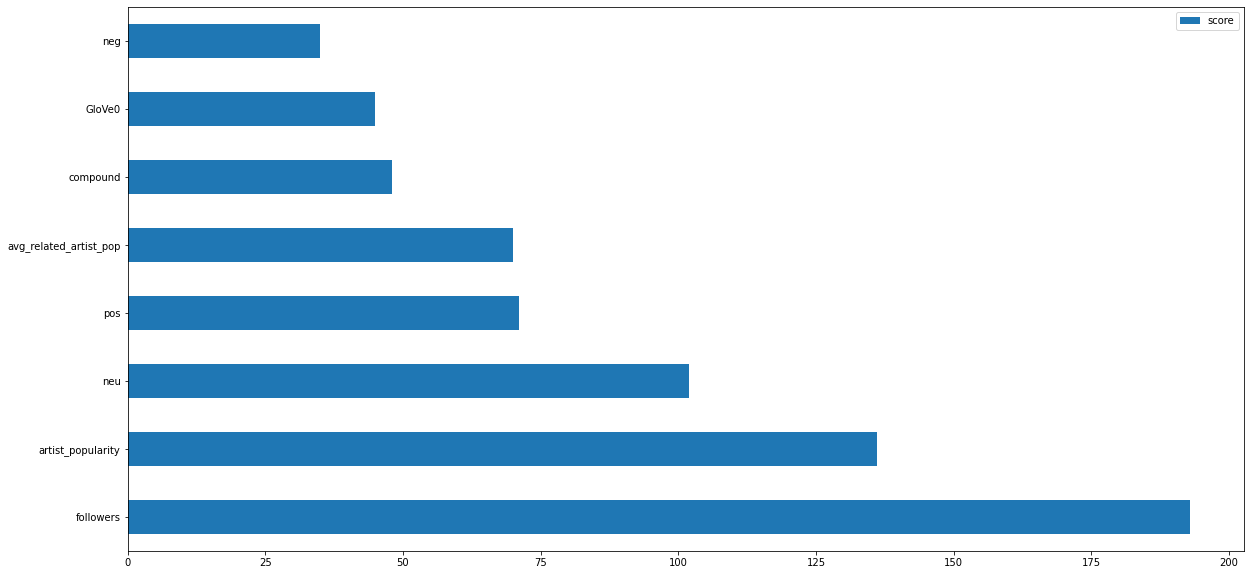

In [ ]:
feature_important = XGB_hyperparam.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
XGB_MVP.save_model('final_model.json')

In [ ]:
full_pred = XGB_hyperparam.predict((xgb.DMatrix(electro_agg_metrics.drop('target', axis = 1))))
electro_agg_metrics['pred'] = full_pred
electro_agg_metrics.to_csv('full_plus_pred.csv')